# Ex 2 - Transfer learning
##### Group: 27
###### Dave Brunner

In [37]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras import layers
from sklearn.metrics import accuracy_score

tf.config.list_physical_devices('GPU')

[]

## Load the Dataset and visualize it

In [38]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

In [39]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

In [40]:
# This step takes too much time. It is not madatory to execute it.
print("Training samples: %d" % train_ds.reduce(0, lambda x,_: x+1).numpy())
print("Validation samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())
print("Tests samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())

Training samples: 15000
Validation samples: 2514
Tests samples: 2514


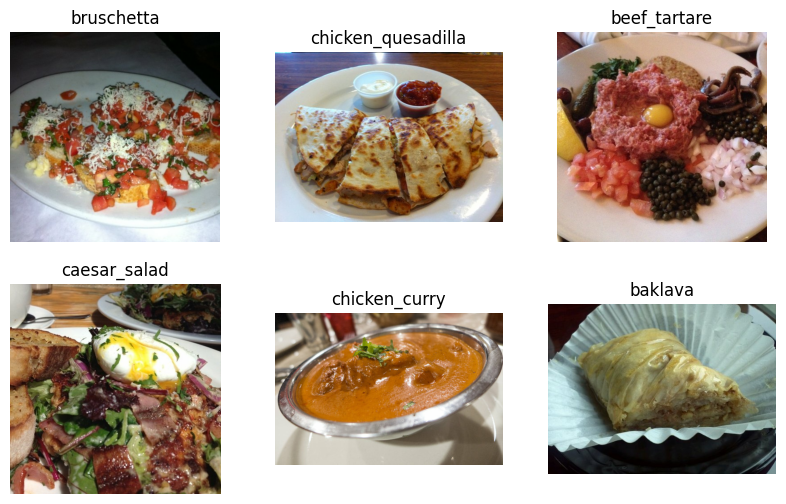

In [41]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

## Resize and normalize

In [42]:
# TODO Resize the images in the training, validation and test set
resize_fn = keras.layers.Resizing(150, 150)
train_ds = train_ds.map(lambda img, label: (resize_fn(img), label))
validation_ds =  validation_ds.map(lambda img, label: (resize_fn(img), label))
test_ds = train_ds.map(lambda img, label: (resize_fn(img), label))

## Data-Augmentation

In [43]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda img, label: (data_augmentation(img), label))

In [44]:
from tensorflow import data as tf_data
batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

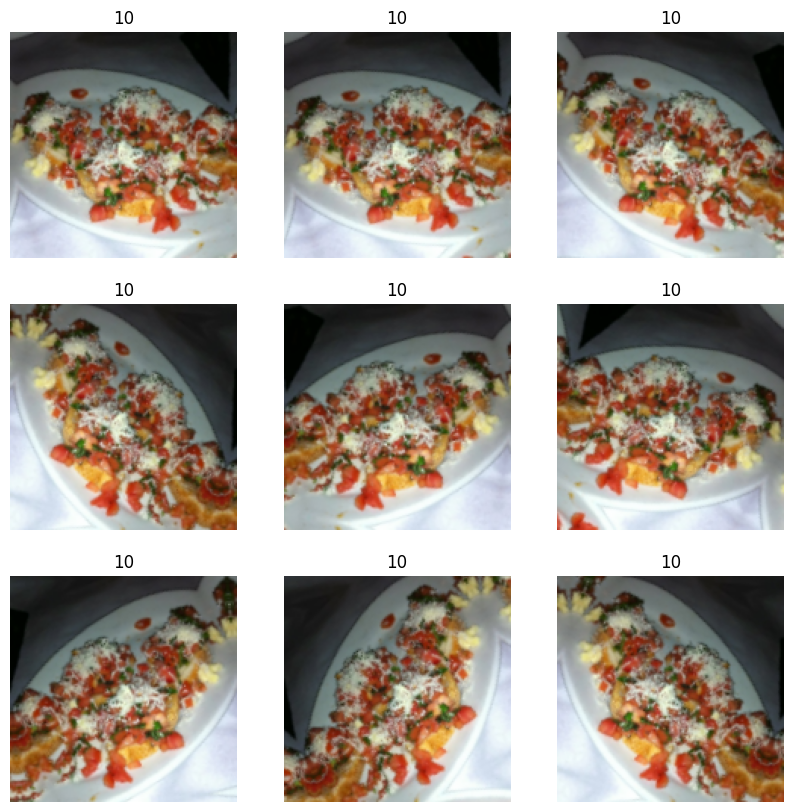

In [45]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")


In [46]:
# # Normalize the images
norm_fn = keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda img, label: (norm_fn(img), label))
validation_ds = validation_ds.map(lambda img, label: (norm_fn(img), label))
test_ds = test_ds.map(lambda img, label: (norm_fn(img), label))

In [47]:
# # One hot encode the labels
train_ds = train_ds.map(lambda img, label: (img, tf.one_hot(label, N_CLASSES)))
validation_ds = validation_ds.map(lambda img, label: (img, tf.one_hot(label, N_CLASSES)))
test_ds = test_ds.map(lambda img, label: (img, tf.one_hot(label, N_CLASSES)))

## Training
### Step 1: Only train the head of the network

In [48]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models. 
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours. 
# A model like mobilenet is more than enough for the exercise.

base_model = keras.applications.MobileNet(
    input_shape=(150, 150, 3),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


# Freeze the base_model
base_model.trainable = False

# Create the model structure
inputs = keras.Input(shape=(150, 150, 3))   

outputs = keras.layers.GlobalAveragePooling2D()(base_model(inputs, training=False))
outputs = keras.layers.Dense(N_CLASSES, activation='softmax')(outputs)
model = keras.Model(inputs, outputs)

model.summary()

<timed exec>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │        20,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249,364 (12.40 MB)

 Trainable params: 20,500 (80.08 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

CPU times: total: 93.8 ms
Wall time: 308 ms


In [49]:
%%time

# Compile the model with your optimizer, your loss and your metrics
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)
print("Fitting the top layer of the model")

step1_history = model.fit(train_ds, epochs=5, validation_data=validation_ds) # You should us a relatively big learning rate: 1e-3

Fitting the top layer of the model
Epoch 1/5
    235/Unknown 55s 227ms/step - categorical_accuracy: 0.2722 - loss: 2.6490

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


235/235 ━━━━━━━━━━━━━━━━━━━━ 65s 267ms/step - categorical_accuracy: 0.2727 - loss: 2.6466 - val_categorical_accuracy: 0.5589 - val_loss: 1.4888
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 51s 218ms/step - categorical_accuracy: 0.5562 - loss: 1.4711 - val_categorical_accuracy: 0.5935 - val_loss: 1.3642
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 51s 219ms/step - categorical_accuracy: 0.6114 - loss: 1.2791 - val_categorical_accuracy: 0.6070 - val_loss: 1.3224
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 51s 218ms/step - categorical_accuracy: 0.6449 - loss: 1.1639 - val_categorical_accuracy: 0.6074 - val_loss: 1.3078
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 52s 221ms/step - categorical_accuracy: 0.6705 - loss: 1.0823 - val_categorical_accuracy: 0.6130 - val_loss: 1.3054
CPU times: total: 6min 40s
Wall time: 4min 30s


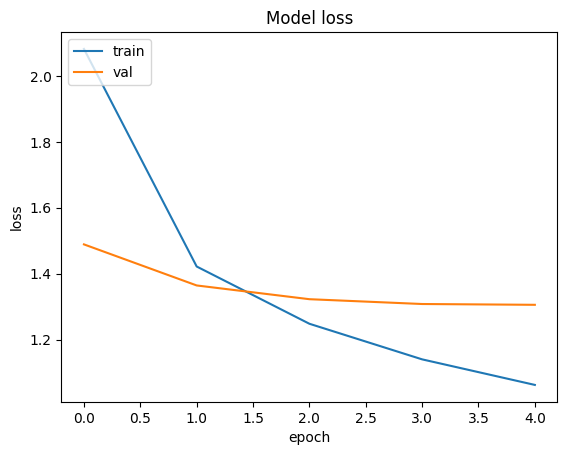

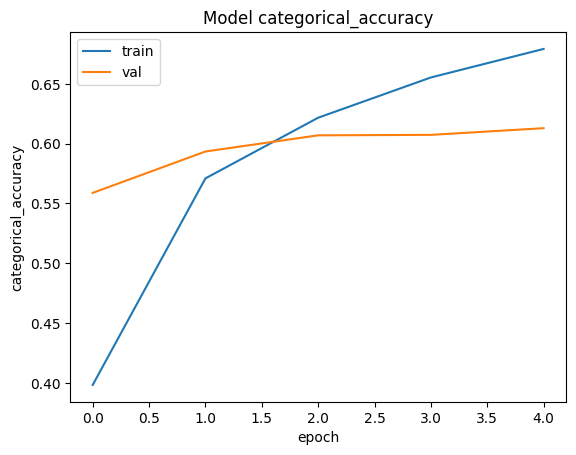

In [52]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_history(step1_history, 'loss')
plot_history(step1_history, 'categorical_accuracy')

### Step 2: Fine-Tune the whole model

In [53]:
%%time


# Unfreeze the pretrained base. 
base_model.trainable = True
base_model.summary(show_trainable=True)

# Compile the model again
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)


# Retrain the model
print("Fine-tuning the model")
step2_history = model.fit(train_ds, epochs=2, validation_data=validation_ds) # You should us a small learning rate: for example 1e-5 or 1e-6

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 75, 75, 32)    │        864 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1_bn                    │ (None, 75, 75, 32)    │        128 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1_relu (ReLU)           │ (None, 75, 75, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_1 (DepthwiseConv2D) │ (None, 75, 75, 32)    │        288 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_1_bn                │ (None, 75, 75, 32)    │        128 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_1_relu (ReLU)       │ (None, 75, 75, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_1 (Conv2D)          │ (None, 75, 75, 64)    │      2,048 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_1_bn                │ (None, 75, 75, 64)    │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_1_relu (ReLU)       │ (None, 75, 75, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pad_2 (ZeroPadding2D)  │ (None, 76, 76, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_2 (DepthwiseConv2D) │ (None, 37, 37, 64)    │        576 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_2_bn                │ (None, 37, 37, 64)    │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_2_relu (ReLU)       │ (None, 37, 37, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_2 (Conv2D)          │ (None, 37, 37, 128)   │      8,192 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_2_bn                │ (None, 37, 37, 128)   │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_2_relu (ReLU)       │ (None, 37, 37, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_3 (DepthwiseConv2D) │ (None, 37, 37, 128)   │      1,152 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_3_bn                │ (None, 37, 37, 128)   │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_3_relu (ReLU)       │ (None, 37, 37, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_3 (Conv2D)          │ (None, 37, 37, 128)   │     16,384 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_3_bn                │ (None, 37, 37, 128)   │        512 │   Y 

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

Fine-tuning the model
Epoch 1/2
235/235 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - categorical_accuracy: 0.4697 - loss: 1.7940 - val_categorical_accuracy: 0.5636 - val_loss: 1.5149
Epoch 2/2
235/235 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - categorical_accuracy: 0.6249 - loss: 1.2367 - val_categorical_accuracy: 0.5772 - val_loss: 1.4306
CPU times: total: 22min 8s
Wall time: 8min 37s


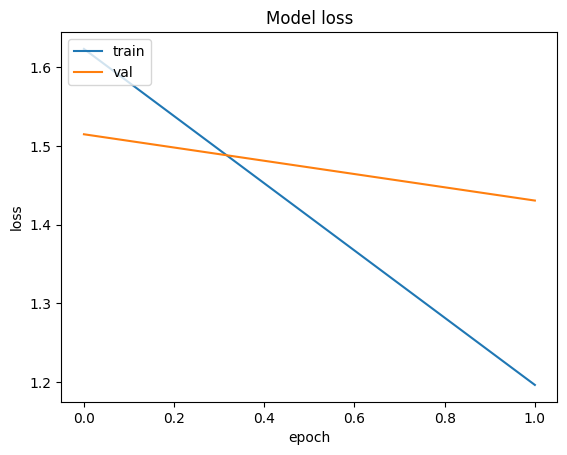

In [54]:
plot_history(step2_history, 'loss')

## Test the fine-tuned model

In [55]:
%%time
# Predict the test set
y_pred = model.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

235/235 ━━━━━━━━━━━━━━━━━━━━ 54s 224ms/step
CPU times: total: 3min 44s
Wall time: 54.7 s


In [56]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.612
CPU times: total: 0 ns
Wall time: 1e+03 µs


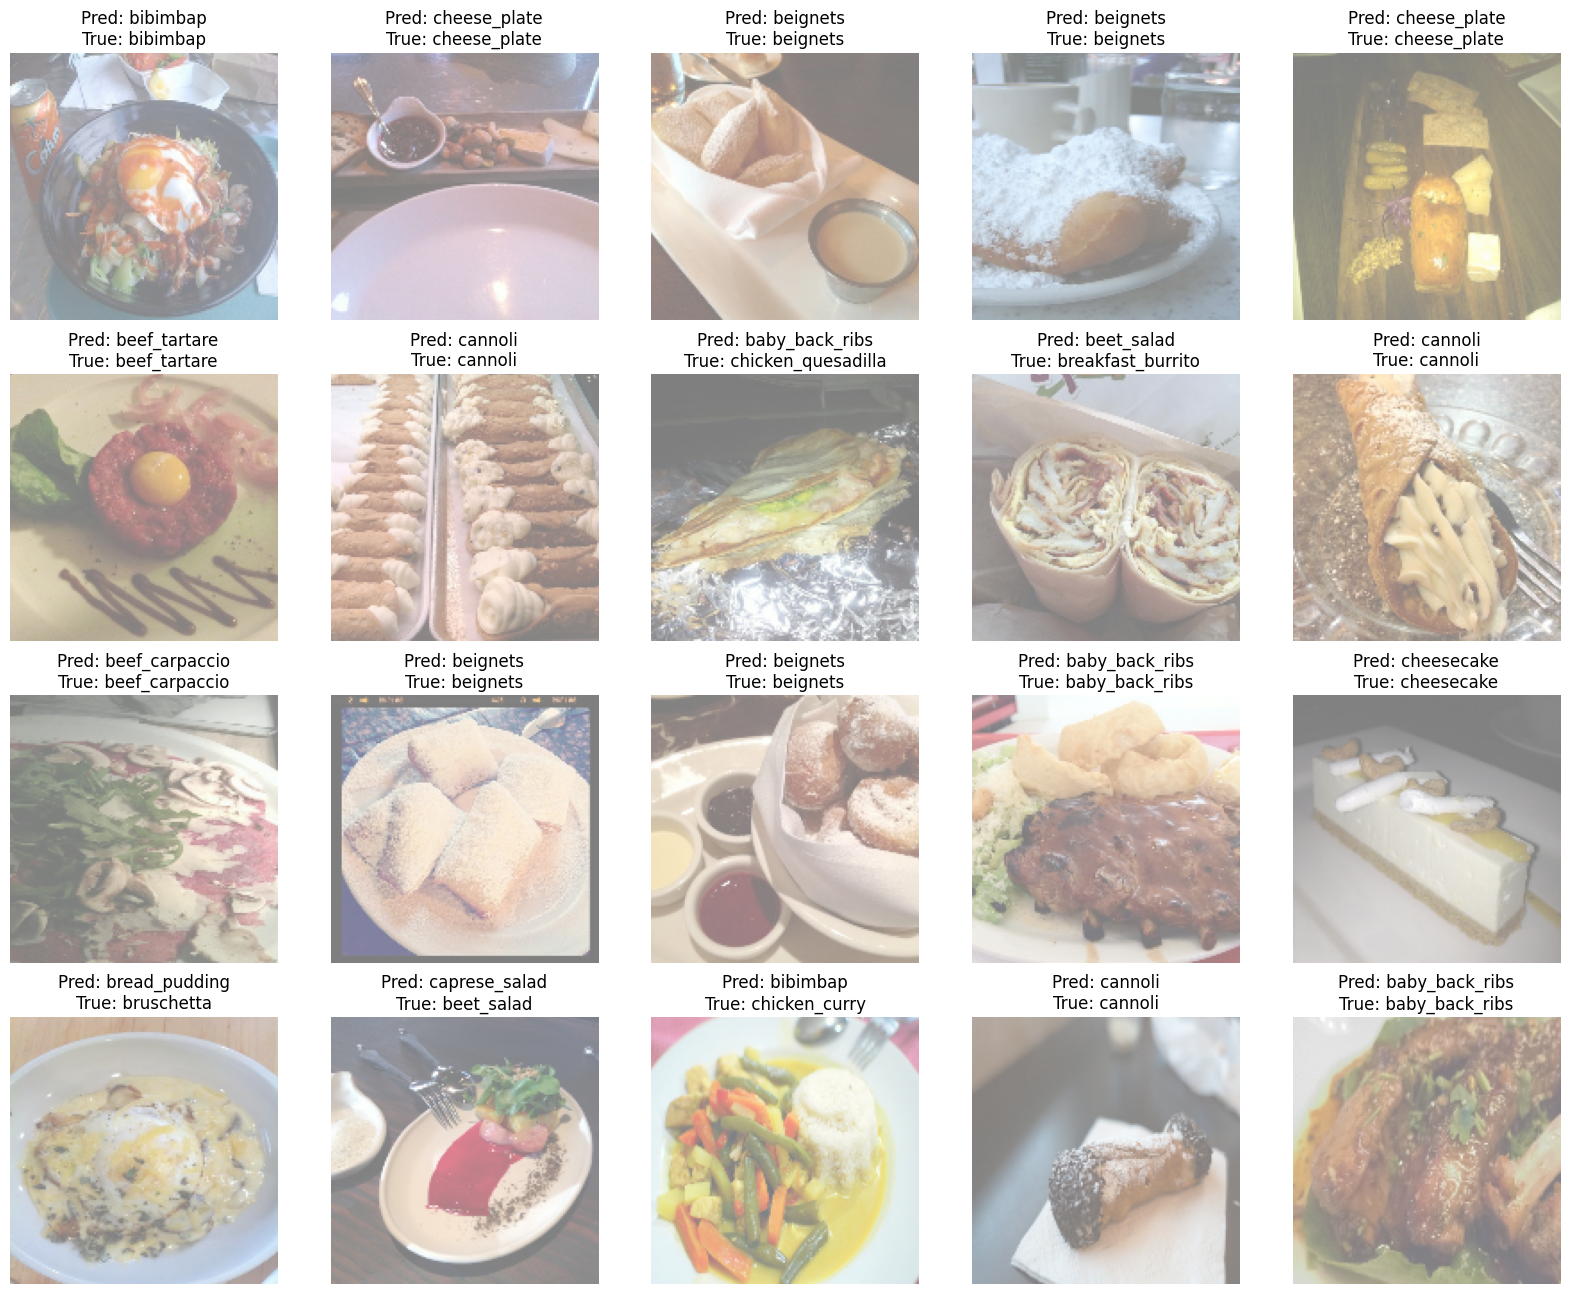

In [57]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")
    
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)

# Conclusion
First the model head was trained for 5 epochs with a learning rate of 1e-3 and then the whole model was then fine-tuned for 2 epochs with a learning rate of 1e-5. 
After training the head of the model the training accuracy was 0.6705 and validation acc was 0.6130.
After the fine-tuning of the whole model the train accuracy was 0.6249 and the validation accuracy was 0.5772.
The final test accuracy was 0.612

When I increased the number of epochs from 2 to 5 during the head-training, the accuracy increased but the validation accuracy decreased.

I think that the performance of the model could further be improved if the first fine-tuning was done for more epochs.

